In [ ]:
#| default_exp resnet

# ResNets

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=160, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(1103)

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

xmean = tensor(0.28)
xstd = tensor(0.35)

@inplace
def transformi(b):
    b["image"] = [(TF.to_tensor(i) - xmean) / xstd for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 1024
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
#| export
act_gr = partial(GeneralReLU, leak=0.1, sub=0.5)

In [ ]:
stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))
cbs = [DeviceCB(), stats, ProgressCB(plot=True), MetricsCB(accuracy=MulticlassAccuracy())]
init_w = partial(init_weights, leak=0.1)

## Going deeper

In [ ]:
def get_model(act=act_gr, nfs=[8,16,32,64,128], norm=nn.BatchNorm2d):
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm, bias=False) for i in range(len(nfs)-1)]
    model = nn.Sequential(conv(1, 8, ks=5, stride=1, act=act, norm=norm), *layers, conv(128, 10, act=False), nn.Flatten())
    return model

In [ ]:
get_model()(xb[:4]).shape

torch.Size([4, 10])

accuracy,loss,epoch,train
0.802,0.553,0,train
0.817,0.776,0,valid
0.866,0.366,1,train
0.869,0.375,1,valid
0.895,0.283,2,train
0.882,0.322,2,valid
0.913,0.236,3,train
0.897,0.287,3,valid
0.930,0.188,4,train
0.912,0.242,4,valid


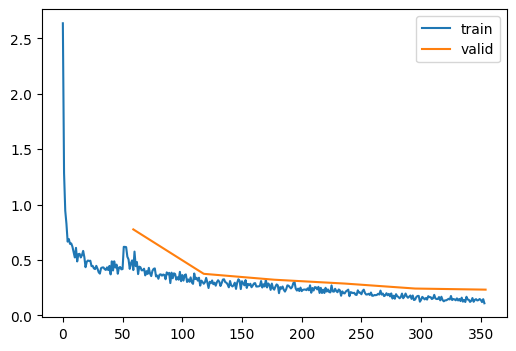

In [ ]:
epochs = 6
lr = 0.07
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103)
model = get_model()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=optim.AdamW)
learn.fit(epochs)

## Skip connections

In [ ]:
#|export
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(
        conv(ni, nf, stride=stride, ks=ks, act=act, norm=norm),
        conv(nf, nf, stride=1, ks=ks, act=False, norm=norm)
    )

In [ ]:
#|export
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni=ni, nf=nf, stride=stride, ks=ks, act=act, norm=norm)
        self.act = act() if act else fc.noop
        self.pool = fc.noop if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)
        self.id_conv = fc.noop if ni == nf else conv(ni, nf, stride=1, ks=1, act=None, norm=None)

    def forward(self, x):
        return self.act(self.convs(x) + self.id_conv(self.pool(x)))

In [ ]:
xb[:4].shape, ResBlock(1, 1)(xb[:4]).shape, ResBlock(1, 2)(xb[:4]).shape, ResBlock(1, 1, 2)(xb[:4]).shape, ResBlock(1, 2, 2, 5)(xb[:4]).shape

(torch.Size([4, 1, 28, 28]),
 torch.Size([4, 1, 28, 28]),
 torch.Size([4, 2, 28, 28]),
 torch.Size([4, 1, 14, 14]),
 torch.Size([4, 2, 14, 14]))

In [ ]:
def get_model(act=act_gr, nfs=[8,16,32,64,128,256], norm=nn.BatchNorm2d):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    model = nn.Sequential(
        ResBlock(1, 8, ks=5, stride=1, act=act, norm=norm), *layers,
        nn.Flatten(), nn.Linear(nfs[-1], 10)
    )
    return model

In [ ]:
get_model()(xb[:4]).shape

torch.Size([4, 10])

In [ ]:
str(xb.shape)[11:-1]

'[1024, 1, 28, 28]'

In [ ]:
def _print_shape(hook, mod, inp, outp):
    print(f"{type(mod).__name__:12}:  {str(inp[0].shape)[11:-1]:18}\t->\t{str(outp.shape)[11:-1]:18}")

In [ ]:
model = get_model()
learn = TrainLearner(
    model, dls, F.cross_entropy,
    cbs=[
        DeviceCB(),
        HooksCallback(_print_shape, lambda x: isinstance(x, (ResBlock, nn.Linear, nn.Flatten))),
        SingleBatchCB()]
)
learn.fit(1, train=False)

ResBlock    :  [1024, 1, 28, 28] 	->	[1024, 8, 28, 28] 
ResBlock    :  [1024, 8, 28, 28] 	->	[1024, 16, 14, 14]
ResBlock    :  [1024, 16, 14, 14]	->	[1024, 32, 7, 7]  
ResBlock    :  [1024, 32, 7, 7]  	->	[1024, 64, 4, 4]  
ResBlock    :  [1024, 64, 4, 4]  	->	[1024, 128, 2, 2] 
ResBlock    :  [1024, 128, 2, 2] 	->	[1024, 256, 1, 1] 
Flatten     :  [1024, 256, 1, 1] 	->	[1024, 256]       
Linear      :  [1024, 256]       	->	[1024, 10]        


In [ ]:
model = get_model()
learn = TrainLearner(
    model, dls, F.cross_entropy,
    cbs=[
        DeviceCB(),
        SingleBatchCB()]
)
with Hooks(model, _print_shape) as hooks:
    learn.fit(1, train=False)

ResBlock    :  [1024, 1, 28, 28] 	->	[1024, 8, 28, 28] 
ResBlock    :  [1024, 8, 28, 28] 	->	[1024, 16, 14, 14]
ResBlock    :  [1024, 16, 14, 14]	->	[1024, 32, 7, 7]  
ResBlock    :  [1024, 32, 7, 7]  	->	[1024, 64, 4, 4]  
ResBlock    :  [1024, 64, 4, 4]  	->	[1024, 128, 2, 2] 
ResBlock    :  [1024, 128, 2, 2] 	->	[1024, 256, 1, 1] 
Flatten     :  [1024, 256, 1, 1] 	->	[1024, 256]       
Linear      :  [1024, 256]       	->	[1024, 10]        


In [ ]:
for i in model[0].convs[0][0].parameters():
    print(i.numel())

200
8


In [ ]:
def summary(learner):
    result = "|Module|Input|Output|Num params|\n|-|-|-|-|\n"
    total = 0
    def _summary(hook, mod, inp, outp):
        nonlocal total, result
        num = sum(i.numel() for i in mod.parameters())
        result += f"|{type(mod).__name__}|{str(inp[0].shape)[11:-1]}|{str(outp.shape)[11:-1]}|{num}|\n"
        total += num

    with Hooks(learner.model, _summary) as hooks:
        learner.fit(1, train=False, cbs=[SingleBatchCB()])
    return result

In [ ]:
sum_str = summary(TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]))
if fc.IN_NOTEBOOK:
    from IPython.display import Markdown
    Markdown(sum_str)

In [ ]:
Markdown(sum_str)

|Module|Input|Output|Num params|
|-|-|-|-|
|ResBlock|[1024, 1, 28, 28]|[1024, 8, 28, 28]|1864|
|ResBlock|[1024, 8, 28, 28]|[1024, 16, 14, 14]|3696|
|ResBlock|[1024, 16, 14, 14]|[1024, 32, 7, 7]|14560|
|ResBlock|[1024, 32, 7, 7]|[1024, 64, 4, 4]|57792|
|ResBlock|[1024, 64, 4, 4]|[1024, 128, 2, 2]|230272|
|ResBlock|[1024, 128, 2, 2]|[1024, 256, 1, 1]|919296|
|Flatten|[1024, 256, 1, 1]|[1024, 256]|0|
|Linear|[1024, 256]|[1024, 10]|2570|


In [ ]:
@fc.patch
def summary(self:Learner):
    result = "|Module|Input|Output|Num params|\n|-|-|-|-|\n"
    total = 0
    def _summary(hook, mod, inp, outp):
        nonlocal total, result
        num = sum(i.numel() for i in mod.parameters())
        result += f"|{type(mod).__name__}|{str(inp[0].shape)[11:-1]}|{str(outp.shape)[11:-1]}|{num}|\n"
        total += num

    with Hooks(self.model, _summary) as hooks:
        self.fit(1, train=False, cbs=[SingleBatchCB()])
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        result = Markdown(result)
    return result

In [ ]:
TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).summary()

|Module|Input|Output|Num params|
|-|-|-|-|
|ResBlock|[1024, 1, 28, 28]|[1024, 8, 28, 28]|1864|
|ResBlock|[1024, 8, 28, 28]|[1024, 16, 14, 14]|3696|
|ResBlock|[1024, 16, 14, 14]|[1024, 32, 7, 7]|14560|
|ResBlock|[1024, 32, 7, 7]|[1024, 64, 4, 4]|57792|
|ResBlock|[1024, 64, 4, 4]|[1024, 128, 2, 2]|230272|
|ResBlock|[1024, 128, 2, 2]|[1024, 256, 1, 1]|919296|
|Flatten|[1024, 256, 1, 1]|[1024, 256]|0|
|Linear|[1024, 256]|[1024, 10]|2570|


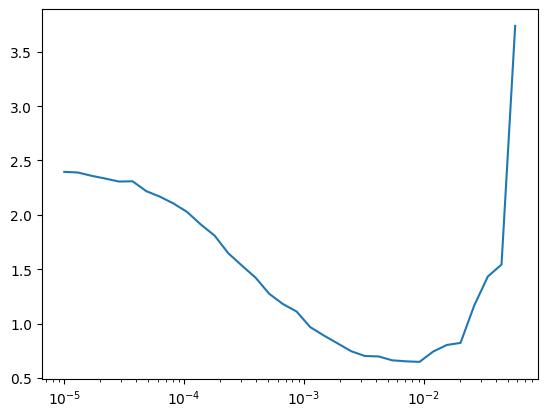

In [ ]:
set_seed(1103, False)
model = get_model()
model = model.apply(init_w)
TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()], opt_func=optim.AdamW).lr_find()

accuracy,loss,epoch,train
0.795,0.566,0,train
0.827,0.597,0,valid
0.872,0.346,1,train
0.865,0.403,1,valid
0.897,0.280,2,train
0.879,0.363,2,valid
0.916,0.225,3,train
0.905,0.266,3,valid
0.935,0.173,4,train
0.917,0.233,4,valid


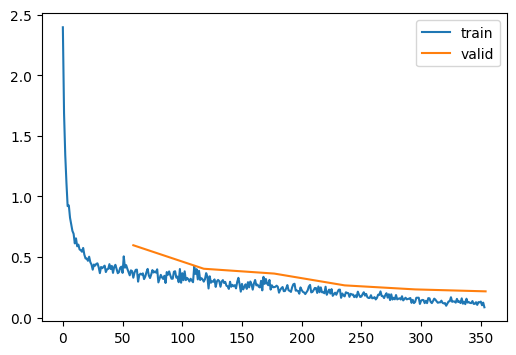

In [ ]:
epochs = 6
lr = 0.02
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=optim.AdamW)
learn.fit(epochs)

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()